In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# definr a run_query() function which get a argument query
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
# define a cun_command() function which takes a sql command as an argument
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
#define a show_table() function to illustrate all tables and views in the .db
def show_table():
    q =  '''
         SELECT
         name,
         type 
         FROM sqlite_master
         WHERE type IN ('table', 'view');
         '''
    return run_query(q)

In [3]:
show_table()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## 哪一种类型的歌在美国的订单最多？

In [4]:
 album_purchase = '''
 WITH track_usa AS
     (
      SELECT il.* FROM invoice_line 'il'
      INNER JOIN invoice 'i' ON i.invoice_id == il.invoice_id
      INNER JOIN customer 'c' ON c.customer_id == i.customer_id
      WHERE c.country == 'USA'
     ) 
     SELECT 
     g.name 'genre',
     COUNT(tu.invoice_line_id) 'quantity',
     CAST(COUNT(tu.invoice_line_id) as float) / (SELECT COUNT(*) FROM track_usa) 'percentage'
     FROM track_usa 'tu'
     INNER JOIN track 't' ON t.track_id == tu.track_id
     INNER JOIN genre 'g' ON g.genre_id == t.genre_id
     GROUP BY 1
     ORDER BY 2 DESC;
     '''
run_query(album_purchase)

,genre,quantity,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


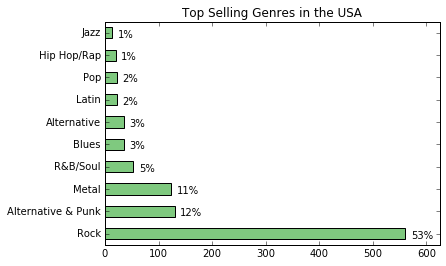

In [5]:
gen_sales_usa = run_query(album_purchase)
gen_sales_usa = gen_sales_usa[:10]
gen_sales_usa.set_index('genre', inplace=True, drop=True)

gen_sales_usa['quantity'].plot.barh( 
                       title = "Top Selling Genres in the USA",
                       xlim = (0,625),
                       colormap=plt.cm.Accent) #plt.cm是设置color map? Accent?
plt.ylabel('')

for i, label in enumerate(list(gen_sales_usa.index)): #enumerate函数同时返回索引和值！
    score = gen_sales_usa.loc[label, "quantity"]
    text = (gen_sales_usa.loc[label, "percentage"]*100).astype(int).astype(str) + '%'
    plt.annotate(str(text),(score+10, i-0.2))   #plt.annotate加文本

plt.show()

由上表及图可知，在美国地区销量前三的音乐类别分别是: rock, punk, metal。

所以，在这四位艺术家中，应该选择：red tone(punk), slim jim bites(blues), meteor and the girls(pop)。

In [6]:
employee_performance = '''
    SELECT 
    e.first_name||' '||e.last_name 'employee name',
    SUM(i.total) 'total sales'
    FROM employee 'e'
    INNER JOIN customer 'c' ON c.support_rep_id == e.employee_id
    INNER JOIN invoice 'i' ON i.customer_id == c.customer_id
    GROUP BY 1
    ORDER BY 2 DESC;
    '''
run_query(employee_performance)

,employee name,total sales
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


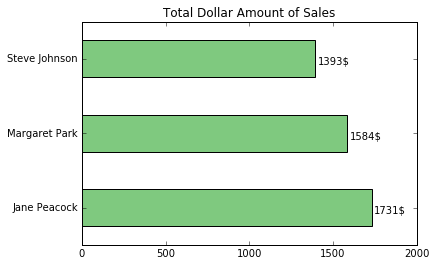

In [7]:
performance = run_query(employee_performance)
performance.set_index("employee name", inplace=True, drop=True)
performance["total sales"].plot.barh(title = "Total Dollar Amount of Sales",
                                     xlim = (0,2000),
                                    colormap = plt.cm.Accent)
plt.ylabel('')

for i, label in enumerate(list(performance.index)):
    score = performance.loc[label, "total sales"].astype(int)
    text = str(score) + '$'
    plt.annotate(str(text), (score+15, i-0.08))

plt.show()

由上图可知，三个人中业绩最好的是Jane Peacock。

## 各个国家的销售情况

In [8]:
c = '''DROP VIEW country_sales'''
run_command(c)

In [9]:
c = '''
CREATE VIEW country_sales AS
    SELECT
        c.country,
        COUNT(DISTINCT c.customer_id) 'total_customers',
        SUM(il.unit_price) 'total_sales',
        COUNT(DISTINCT i.invoice_id) 'total_order'
    FROM customer 'c'
    INNER JOIN invoice 'i' ON i.customer_id == c.customer_id
    INNER JOIN invoice_line 'il' ON il.invoice_id == i.invoice_id
    GROUP BY 1;
'''
run_command(c)

In [10]:
q = '''select * from country_sales'''
run_query(q)

,country,total_customers,total_sales,total_order
0,Argentina,1,39.60,5
1,Australia,1,81.18,10
2,Austria,1,69.30,9
3,Belgium,1,60.39,7
4,Brazil,5,427.68,61
5,Canada,8,535.59,76
6,Chile,1,97.02,13
7,Czech Republic,2,273.24,30
8,Denmark,1,37.62,10
9,Finland,1,79.20,11


In [11]:
country_purchase = '''
WITH other AS
    (
    SELECT
        CASE
            WHEN total_customers == 1 THEN 'Other'
            ELSE country
            END AS 'country',
        SUM(total_customers) 'total_customers',
        SUM(total_sales) 'total_sales',
        CAST(SUM(total_sales) as float) / SUM(total_customers) 'avg_sales',
        CAST(SUM(total_order) as float) / SUM(total_customers) 'avg_order_numbers'
    FROM country_sales 
    GROUP BY 1
    )
    
SELECT 
    country,
    total_customers,
    total_sales,
    avg_sales,
    avg_order_numbers
FROM                                
    (
     SELECT 
        country,
        total_customers,
        total_sales,
        avg_sales,
        avg_order_numbers,
        CASE 
            WHEN country == 'Other' THEN 1
            ELSE 0
        END AS 'sort'
     FROM other
     ORDER BY 6 ASC, 3 DESC
     )
'''
run_query(country_purchase)  
# 上面语句有两点需要注意：1.在with那一段添加sort列令other=1从而排序使other位于最底部行不通，因为
# with那一段才将人数为1 的国家归为other，当前的操作表中并没有该项，下面对other调整行不通，没办法动态填充！
# 2. order by b, c 两列，先对b排序,然后在第一次排序结果上对第二列排序！

,country,total_customers,total_sales,avg_sales,avg_order_numbers
0,USA,13,1040.49,80.037692,10.076923
1,Canada,8,535.59,66.948750,9.500000
2,Brazil,5,427.68,85.536000,12.200000
3,France,5,389.07,77.814000,10.000000
4,Germany,4,334.62,83.655000,10.250000
5,Czech Republic,2,273.24,136.620000,15.000000
6,United Kingdom,3,245.52,81.840000,9.333333
7,Portugal,2,185.13,92.565000,14.500000
8,India,2,183.15,91.575000,10.500000
9,Other,15,1094.94,72.996000,9.800000


## 销售情况数据可视化（未完成）

## 购买整张专辑的有多少？

In [13]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id 'invoice_id',
         MIN(il.track_id) 'first_track_id'
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) 'number_of_invoices',
    CAST(count(invoice_id) as float) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) 'percent'
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track 't'
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track 't2'
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line 'il2'
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line 'il2'
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track 't'
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track 't2'
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN 'yes'
             ELSE 'no'
         END AS 'album_purchase'
     FROM invoice_first_track ifs
    )
GROUP BY 1
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


可见，购买整张专辑的只有18.6%。因此，推荐购买一张专辑中的几首流行曲目。